The following is the implementation of an academic example given in the **paper "Hermite interpolation with retractions on manifolds"** that illustrates the RH interpolation scheme on manifolds demonstrated on a smooth svd curve on the manifold of rank k matrices, viewed as a submanifold of $\mathbb{R}^{n \times m}$.  


We first create our list of scalars $t_0, …, t_{N} ∈ [-0.5,0.5] $ on top of which we will create our manifold data $$\space$$ $$(\gamma(t_i), \dot{\gamma}(t_i))_{i = 0}^{N} \in T\mathcal{M}, $$ $$\space$$ Using the smooth svd manifold curve $\gamma:[-0.5, 0.5] → \mathcal{M} \subset \mathbb{R}^{n \times m}$ $$\space$$ Note: the number of sampling points was taken according to the experiment done in the paper.

In [98]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random


In [99]:
device = 'cpu'
sampling_size = 0.25
lower_point = -0.5
sampling_points = [lower_point + i*sampling_size for i in range(int(abs(lower_point)*2/sampling_size)+1)]


Now we construct the manifold curve and it's approximated derivative as shown in the paper **"Hermite interpolation with retractions on manifolds"** in 5.2.4 (the curve) and 5.2.2 (the derivative approximation), the curve is given by:$$\space$$ $$Y(t) = Y_0 + tY_1 + t^2Y_2 + t^3Y_3, \space\space Y_i \in \mathbb{R}^{m \times r}$$ $$\space$$ $$Z(t) = Z_0 + tZ_1 + t^2Z_2, \space\space Z_i \in \mathbb{R}^{n \times r},$$ $$\space$$ $$γ(t) = Y(t)Z(t)^{T}, \space\space t \in [-0.5,0.5] $$ $$\space$$
The approximation of the derivative of $γ(t)$ as proposed in the paper in section 5.2.2 is calculated via the projection of the centered finite differences on $T_{γ(t)}\mathcal{M}$:$$\space$$ $$ \dot{γ}(t) ≃ Π_{γ(t)}(\frac{γ(t + Δt) - \gamma(t - Δt)}{2Δt}), \space\space Δt = 10^{-5}$$ $$\space$$ The projection of some $Z ∈ \mathbb{R}^{n \times m}$ onto $T_{\gamma(t)}\mathcal{M}$ is found in the paper **"Low-rank retractions: a survey and new results"** at section 2.1. If the curve $γ$ is given by $\gamma(t) = U(t)Σ(t)V(t)^{T}$ then the projection is given by:$$\space$$ $$ Π_{\gamma(t)}(Z) = ZVV^{T} + UU^{T}Z - UU^{T}ZVV^{T} $$ $$\space$$ **NOTE**: To insure that the svd curve will be smooth, we use the normalization of the svd given in the paper **"Hermite interpolation and data processing errors on Riemannian matrix manifolds"** in section 5.3 Remark 3.

In [81]:
def smooth_svd_curve(m, n, rank):
    torch.manual_seed(42)
    Y_0 = torch.randn(m, rank, dtype=torch.float64).to(device)
    Y_1 = 0.5*torch.randn(m, rank, dtype=torch.float64).to(device)
    Y_2 = 0.5*torch.randn(m, rank, dtype=torch.float64).to(device)
    Y_3 = 0.5*torch.randn(m, rank, dtype=torch.float64).to(device)

    Z_0 = torch.randn(n, rank, dtype=torch.float64).to(device)
    Z_1 = 0.5*torch.randn(n, rank, dtype=torch.float64).to(device)
    Z_2 = 0.5*torch.randn(n, rank, dtype=torch.float64).to(device)

    Y = lambda t: Y_0 + t*Y_1 + (t**2)*Y_2 + (t**3)*Y_3
    Z = lambda t: Z_0 + t*Z_1 + (t**2)*Z_2
    W = lambda t: Y(t)@Z(t).T
    U = lambda t: torch.linalg.svd(W(t), full_matrices=False)[0]
    Sigma = lambda t: torch.diag(torch.linalg.svd(W(t), full_matrices=False)[1])
    V = lambda t: torch.linalg.svd(W(t), full_matrices=False)[2]

    # Making the SVD decomposition path smooth following R. Zimmermann "Hermite interpolation
    # and data processing errors on Riemannian matrix manifolds" section 5.3 Remark 3

    U_0 = torch.linalg.svd(W(-0.5), full_matrices=False)[0]
    S = lambda t: torch.diag(torch.sign(torch.linalg.diagonal(U(t).T@U_0)))
    svd_smooth_path = lambda t: U(t)@S(t)@Sigma(t)@S(t)@V(t)

    return svd_smooth_path


def svd_curve_derivative(t, m, n, rank):
    A = smooth_svd_curve(m, n, rank)
    U, S, V = torch.linalg.svd(A(t), full_matrices=False)
    delta_t = 1e-5
    centred_diff = (1/(2*delta_t))*(A(t + delta_t) - A(t - delta_t))
    A_dot = centred_diff@V.T@V + U@U.T@centred_diff - U@U.T@centred_diff@V.T@V  # The orthogonal projection on T_(A(t))M
    return A_dot

**Some sanity checks for the manifold curve implemented above:** $$\space$$
Here, in order to sanity check the derivative of our curve we gonna use the following usefull facts introduced in the paper **"Low-rank retractions: a survey and new results"**: $$T_{X}\mathcal{M}_{r} = \{U\dot{S}V^{T} + U_{p}V^{T} + UV_{p}^{T} : U^{T}U_{p} = 0 , V^{T}V_{p} = 0\}$$ The formulas of $\dot{S}$, $U_p$, $V_p$ are given in the paper and inplemented below.

In [82]:
# Sanity check for the manifold svd curve and it's derivative:
# Note that we are using low dimensional example since we are on a 'cpu'
rank_k = 10
m = 15
n = 15
A = smooth_svd_curve(m, n, rank_k)
t = random.uniform(-0.5, 0.5)
A_dot = svd_curve_derivative(t, m, n, rank_k)
U, S, V = torch.linalg.svd(A(t), full_matrices=False)


S_dot = U.T@A_dot@V.T
U_dot = (A_dot@V.T - U@S_dot)@torch.linalg.inv(torch.diag(S))
V_dot = (A_dot.T@U - V.T@S_dot.T)@torch.linalg.inv(torch.diag(S))

U_p = U_dot@torch.diag(S)
V_p = V_dot@torch.diag(S)


assert torch.linalg.matrix_rank(A(t)) == rank_k, \
    "Our manifold curve is not on the manifold of rank k matrices"
assert torch.linalg.matrix_norm(V@V_p) <= 1e-10, \
    "A_dot is not in the tangent space"
assert torch.linalg.matrix_norm(U.T@U_p) <= 1e-10, \
    "A_dot is not in the tangent space"


Next we implement the specific retraction map and it's inverse that was used by the authors called the Orthographic retraction. The implementatin is based on the closed formula representation presented in the paper **"Low-rank retractions: a survey and new results"** in sectoin 3.2

In [83]:
def retraction(X, Z):
    # The following representation of X, Z and the retraction R(X,Z) is as shown in
    # the article "Low-rank retractions: a survey and new results"

    # First we represent X, the manifold element and Z, the element of the tangent space at X
    # as shown in (5) and (12) in the article.
    U, S, V = torch.linalg.svd(X, full_matrices=False)

    # I've added the following trancation since otherwise the output of the
    # retraction is not of rank 10 due to numerical instability
    U = U[:, :10]
    S = S[:10]
    V = V[:10, :]

    S_dot = U.T@Z@V.T
    U_dot = (Z@V.T - U@S_dot)@torch.linalg.inv(torch.diag(S))
    V_dot = (Z.T@U - V.T@S_dot.T)@torch.linalg.inv(torch.diag(S))

    U_p = U_dot@torch.diag(S)
    V_p = V_dot@torch.diag(S)
    Z = U@S_dot@V + U_p@V + U@V_p.T

    # Now by using these representations we construct R(X,X_dot) as shown in 3.2
    R = (U@(torch.diag(S) +S_dot) + U_p)@torch.linalg.inv(torch.diag(S) + S_dot)@((torch.diag(S) + S_dot)@V + V_p.T)

    return R


def inv_retraction(X, Y):
    # Here we implement the inverse retraction with foot at X inv(R_X(Y))
    # as shown in 3.2.3
    U, S, V = torch.linalg.svd(X, full_matrices=False)
    U_Y, S_Y, V_Y = torch.linalg.svd(Y, full_matrices=False)
    S_Y = torch.diag(S_Y)
    S = torch.diag(S)
    I_U = torch.eye((U@U.T).shape[0]).to(device)
    I_V = torch.eye((V.T@V).shape[0]).to(device)

    R_inv = ((I_U - U@U.T)@U_Y@S_Y@V_Y@V.T)@V + U@(U.T@U_Y@S_Y@V_Y@(I_V - V.T@V)) + U@(U.T@U_Y@S_Y@V_Y@V.T - S)@V
    return R_inv

**Some sanity checks for the retraction and its inverse implemented above:**

In [100]:
# Sanity check for the retraction and it's inverse:
# Note that we are using low dimensional example since we are on a 'cpu'
rank_k = 10
m = 15
n = 15
A = smooth_svd_curve(m, n, rank_k)
t = random.uniform(-0.5, 0.5)
A_dot = svd_curve_derivative(t, m, n, rank_k)
delta_t = 1e-5
Z = torch.zeros_like(A(t))

assert torch.linalg.matrix_rank(retraction(A(t), A_dot)) ==rank_k, \
    "The output of the retraction is outside of the manifold"

assert torch.linalg.matrix_norm(retraction(A(t + delta_t), inv_retraction(A(t + delta_t), A(t))) - A(t), 'fro') <= 1e-10,\
    "The composite of the retraction with its inverse is not the identity map"

assert  torch.linalg.matrix_norm(inv_retraction(A(t), retraction(A(t), delta_t*A_dot) - delta_t*A_dot), 'fro') <= 1e-8,\
    "The composite of the inverse retraction with the restraction is not the identity map"
# I acknowledge the fact that I took 1e-8 for the test above at the end.
# I have a strong feeling that this might be the source of the problems here.

assert torch.linalg.matrix_norm(retraction(A(t), Z) - A(t), 'fro') <= 1e-10,\
                            "R(X,0) != X"

assert torch.linalg.matrix_norm(inv_retraction(A(t), A(t)),'fro') <= 1e-10,\
                            "invR(X,X) != 0"


Next we implement the family of enpoint retraction curves given by:$$\space$$ $$
c_{r}(t;x,y) = R_{q(r)}((1-t)R_{q(r)}^{-1}(x) + tR_{q(r)}^{-1}(y))$$ $$\space$$ where $q(r) = R_{x}(rR_{x}^{-1}(y))$, $\space$  $r,t \in [0,1]$ and $\space x,y \in \mathcal{M}$ .

In [101]:
def c_curve(r, tau, x, y):
    q = retraction(x, r*inv_retraction(x, y))
    return retraction(q, (1-tau)*inv_retraction(q, x) + tau*inv_retraction(q, y))

**Some sanity checks for the c_r retraction endpoint curve implemented above:**

In [102]:
# Sanity checks for the c_r endpoint retraction curve:
# Note that we are using low dimensional example since we are on a 'cpu'
rank_k = 10
m = 100
n = 30
A = smooth_svd_curve(m, n, rank_k)
t = random.uniform(-0.5, 0.5)
delta_t = 1e-5
r = random.uniform(0, 1)
Z = torch.zeros_like(A(t))

def c_r_derivative(s, r):
    delta_t = 1e-5
    U, S, V = torch.linalg.svd(c_curve(r, s, A(t), A(t + delta_t)), full_matrices=False)
    centred_diff = (1/(2*delta_t))*(c_curve(r, s + delta_t, A(t), A(t + delta_t)) - c_curve(r, s - delta_t, A(t), A(t + delta_t)))
    A_dot = centred_diff@V.T@V + U@U.T@centred_diff - U@U.T@centred_diff@V.T@V
    return A_dot

assert torch.linalg.matrix_norm(c_curve(r, 0, A(t), A(t+delta_t)) - A(t), 'fro') <= 1e-10,\
                            "C_r(0;x,y) != x"
assert torch.linalg.matrix_norm(c_curve(r, 1, A(t), A(t+delta_t)) - A(t + delta_t), 'fro') <= 1e-10,\
                            "C_r(1;x,y) != y"
assert torch.linalg.matrix_norm(c_r_derivative(0, 0) - inv_retraction(A(t), A(t + delta_t)) ) <= 1e-8, \
                            "C_0_dot(0;x,y) != inv_R(x,y)"
assert torch.linalg.matrix_norm(c_r_derivative(0, 0) - inv_retraction(A(t), A(t+ delta_t)) ) <= 1e-8, \
                            "C_1_dot(1;x,y) != -inv_R(y,x)"



Next we finaly implement the main two algorithms of the paper.
 Algorithm 1 is the offline phase in which we precompute the quantities  defining the RH interpolant and algorithm 2 is the online phase in which we evaluate the RH interpolant at a point t. $$\space$$ The algorithms are given in the paper as pseudocode.

In [103]:
def offline_phase(bundle_data, points):
    n = len(points)
    output = []
    for i in range(n-1):
        h = points[i+1] - points[i]
        p_plus = retraction(bundle_data[i][0], (1/3)*h*bundle_data[i][1])
        p_minus = retraction(bundle_data[i+1][0], -(1/3)*h*bundle_data[i+1][1])
        q = retraction(p_plus, 0.5*inv_retraction(p_plus, p_minus))
        w_plus = inv_retraction(q, p_plus)
        w_minus = inv_retraction(q, p_minus)
        output.append([q, w_plus, w_minus])
    return output


def largest_point_finder(t, points):
    n = len(points)
    for i in range(n-1):
        if points[i] > t:
            return i-1
    return n-2


def online_evaluation_phase(t, offline_output, bundle_data, points):
    i = largest_point_finder(t, points)
    q = offline_output[i][0]
    w_plus = offline_output[i][1]
    w_minus = offline_output[i][2]
    p = bundle_data[i][0]
    v = bundle_data[i][1]
    p_plus = bundle_data[i+1][0]
    v_plus = bundle_data[i+1][1]

    h = points[i + 1] - points[i]
    tau = (t - points[i])/h
    beta_0 = retraction(p, (tau/3)*h*v)
    beta_1 = retraction(q, (1-tau)*w_plus + tau*w_minus)
    beta_2 = retraction(p_plus, ((1-tau)/3)*h*v_plus)  # Here I found a misprint in the Pseudo code given in the paper
    beta_01 = c_curve(0, tau, beta_0, beta_1)
    beta_12 = c_curve(1, tau, beta_1, beta_2)
    beta = c_curve(tau, tau, beta_01, beta_12)
    return beta



**Next we plot the pointwise interpolation error:$$\space$$$$E_{1}(t) = ||H(t) - γ(t)||_{F} \space\space\space t \in [-0.5, 0.5]$$ $$\space$$and the pointwise derivative error:** $$\space$$ $$E_{2}(t) = || \dot{H}(t) - \dot{γ}(t)||_{F} \space\space\space t \in [-0.5, 0.5]$$ $$\space$$

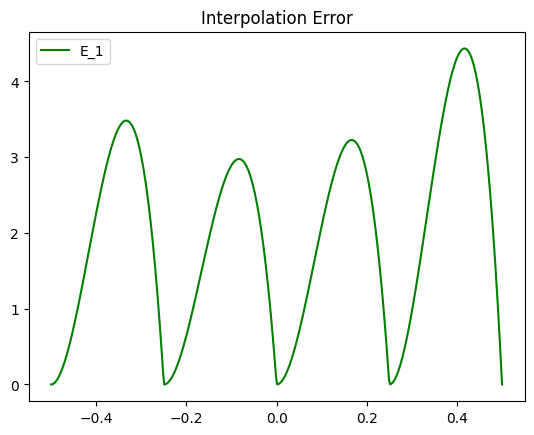

In [88]:
A = smooth_svd_curve(10**2, 30, 10)
bundle__data = [[A(i), svd_curve_derivative(i, 10**2, 30, 10)] for i in sampling_points]
offline_outputt = offline_phase(bundle__data, sampling_points)

x = np.linspace(-0.5, 0.5, 400)  # 400 points between -0.5 and 0.5

y_f = [A(i) for i in x]
y_g = [online_evaluation_phase(i, offline_outputt, bundle__data, sampling_points) for i in x]

y_diff = [torch.linalg.matrix_norm( y_f[i] - y_g[i] , 'fro').to('cpu') for i in range(400)]
fig, ax = plt.subplots()
ax.plot(x, y_diff, label='E_1', color='green')
ax.set_title('Interpolation Error')
ax.legend()
plt.show()




**Sanity check for the final interpolant:**

In [104]:
# Cheking that the final interpolant actually interpolates our data
rank = 10
m = 100
n = 30
A = smooth_svd_curve(m, n, rank)
bundle__data = [[A(i), svd_curve_derivative(i, 10**2, 30, 10)] for i in sampling_points]
offline_outputt = offline_phase(bundle__data, sampling_points)
x = [torch.linalg.matrix_norm(A(i) - online_evaluation_phase(i, offline_outputt, bundle__data, sampling_points), 'fro') for i in sampling_points]
x.sort()

assert x[-1] <= 1e-10, \
    "The final interpolant does not interpolate our data"



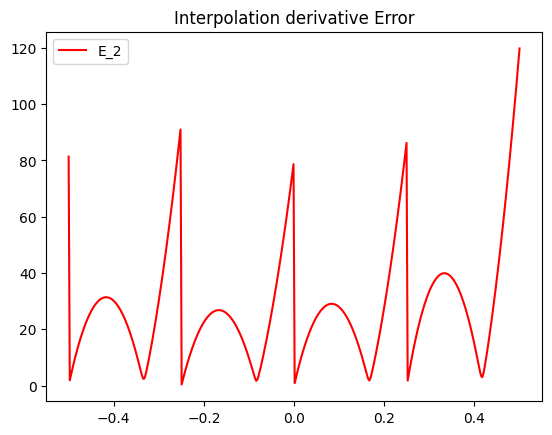

In [105]:
A = smooth_svd_curve(10**2, 30, 10)
bundle__data = [[A(i), svd_curve_derivative(i, 10**2, 30, 10)] for i in sampling_points]
offline_outputt = offline_phase(bundle__data, sampling_points)

U_0 = torch.linalg.svd(online_evaluation_phase(-0.5, offline_outputt, bundle__data, sampling_points), full_matrices=False)[0]


x = np.linspace(-0.5, 0.5, 400)  # 400 points between -0.5 and 0.5


def interpolant_derivative(t):
    U, S, V = torch.linalg.svd(online_evaluation_phase(t, offline_outputt, bundle__data, sampling_points), full_matrices=False)

    S = torch.diag(torch.sign(torch.linalg.diagonal(U.T@U_0)))
    U = U@S
    V = S@V
    delta_t = 1e-5
    centred_diff = (1/(2*delta_t))*(online_evaluation_phase(t + delta_t, offline_outputt, bundle__data, sampling_points) - online_evaluation_phase(t - delta_t, offline_outputt, bundle__data, sampling_points))
    A_dot = centred_diff@V.T@V + U@U.T@centred_diff - U@U.T@centred_diff@V.T@V
    return A_dot

y_f_dot =  [svd_curve_derivative(i, 10**2, 30, 10) for i in x ]
y_g_dot =  [interpolant_derivative(i) for i in x]


y_diff_dot = [torch.linalg.matrix_norm(y_f_dot[i] - y_g_dot[i] , 'fro').to('cpu') for i in range(400)]
fig, ax = plt.subplots()
ax.plot(x, y_diff_dot, label='E_2', color='red')
ax.set_title('Interpolation derivative Error')
ax.legend()
plt.show()



# What in my opinion causes the inability of the derivative interpolation:

As I have shown above in the sanity checks, the endpoint family of retraction curves  $c_r$ upon which the final interpolant is built does indeed work as an endpoint curve and hence the first order interpolation works just fine. The problem arises when we continue to the interpolation of the derivatives. Let me remind us some notation from the paper so it will be more convenient to speculate what went wrong. I remind that the final interpolant is of the form $$\space$$ $$H:[t_0,t_N] → \mathcal{M}$$ $$\space$$ $$H(t)|_{[t_i,t_{i+1}]} = α(\frac{t - t_i}{h_i};p_i, h_iv_i, p_{i+1}, h_iv_{i+1}), \space\space i = 0, \dots, N-1 $$ Where $$\space$$ $$\alpha(t;p_0,v_0,p_1,v_1) := β(t;p_0,p_{0}^{+}, p_{1}^{-}, p_1)$$ Is the generalized de Casteljau curve between $p_0$ and $p_1$ with 4 control points. $$\space$$ We recall that the final interpolant $H$ is computing the derivatives at the sampled points (Which are the enpoints of α) thanks to the property of $α$ given by $$\space$$ $$\dot{α}(0) = 3R_{p_0}^{-1}(R_{p_0}(\frac{1}{3}v_0)) = v_0$$ $$\dot{α}(1) = -3R_{p_1}^{-1}(R_{p_1}(-\frac{1}{3}v_1)) = v_1$$ Hence we see that for maximal numerical accuracy the retraction and it's inverse should act as closely as possible to the identity map when composed. Theoretically we know that $R_{p_1}^{-1} ∘ R_{p_1} = Id$ in some neighborhood of the origin in $T_{p_1}\mathcal{M}$. Practically what we see via numerical experimentation is that this neighborhood is very small and in our case does not include $\frac{h_i}{3}v_i \in T_{p_i}\mathcal{M}$. We demonstrate it with code in the following code cell:

In [106]:
# First create our data that is used in the example:
h = 0.25
rank_k = 10
m = 10**2
n = 30
A = smooth_svd_curve(m, n, rank_k)
t = random.uniform(-0.5, 0.5)
A_dot = svd_curve_derivative(t, m, n, rank_k)
delta_t = 1e-10
bundle__data = [[A(i), svd_curve_derivative(i, 10**2, 30, 10)] for i in sampling_points]  #This is our (p_i,v_i) tangent bundle sampling points


# Taking the first two tangent bundle data points for example
p_0 = bundle__data[0][0]
v_0 = bundle__data[0][1]
p_1 = bundle__data[1][0]
v_1 = bundle__data[1][1]

# Now as you can see the composite is far from being the identity:
print(torch.linalg.matrix_norm(inv_retraction(p_0, retraction(p_0, (1/3)*h*v_0)) - (1/3)*h*v_0))
print(torch.linalg.matrix_norm(inv_retraction(p_1, retraction(p_1, -(1/3)*h*v_1)) +(1/3)*h*v_1))

# Now let us get closer to the origin by changing (1/3)*h to 1e-10
# and see that in that neighborhood the composite is very close to the identity map:
print(torch.linalg.matrix_norm(inv_retraction(p_0, retraction(p_0, delta_t*v_0)) - delta_t*v_0))
print(torch.linalg.matrix_norm(inv_retraction(p_1, retraction(p_1, -delta_t*v_1)) +delta_t*v_1))

tensor(0.5089, dtype=torch.float64)
tensor(0.2951, dtype=torch.float64)
tensor(2.8596e-13, dtype=torch.float64)
tensor(2.0560e-13, dtype=torch.float64)


As shown above, the composite of the retraction and its inverse is acting close to identity only in a close proximity of the origin in $T_{p_i}\mathcal{M}$ and hence the approximated derivative of the interpolant $\dot{\tilde{A}}(t_i) ≈ \dot{H}(t_i)$ at the sampling points is far from the actual derivative values $v_i$. Furthermore, from that inaccuracy at the sampling points and from the piecewise nature of $H$ we would now expect the derivative to have points of discontinuity at the sampling points. We next plot the norm of the derivative of the interpolant in the interval $[-0.5,0.5]$ to spot the discontinuity points.

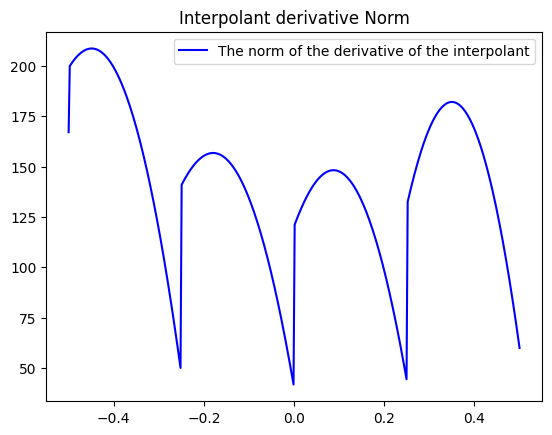

In [110]:
A = smooth_svd_curve(10**2, 30, 10)
bundle__data = [[A(i), svd_curve_derivative(i, 10**2, 30, 10)] for i in sampling_points]
offline_outputt = offline_phase(bundle__data, sampling_points)

U_0 = torch.linalg.svd(online_evaluation_phase(-0.5, offline_outputt, bundle__data, sampling_points), full_matrices=False)[0]


x = np.linspace(-0.5, 0.5, 400)  # 400 points between -0.5 and 0.5


def interpolant_derivative(t):
    U, S, V = torch.linalg.svd(online_evaluation_phase(t, offline_outputt, bundle__data, sampling_points), full_matrices=False)

    S = torch.diag(torch.sign(torch.linalg.diagonal(U.T@U_0)))
    U = U@S
    V = S@V
    delta_t = 1e-10
    centred_diff = (1/(2*delta_t))*(online_evaluation_phase(t + delta_t, offline_outputt, bundle__data, sampling_points) - online_evaluation_phase(t - delta_t, offline_outputt, bundle__data, sampling_points))
    A_dot = centred_diff@V.T@V + U@U.T@centred_diff - U@U.T@centred_diff@V.T@V
    return A_dot


y_g_dot =  [ interpolant_derivative(i) for i in x]


y_diff_dot = [torch.linalg.matrix_norm(y_g_dot[i] , 'fro').to('cpu') for i in range(400)]
fig, ax = plt.subplots()
ax.plot(x, y_diff_dot, label='The norm of the derivative of the interpolant', color='blue')
ax.set_title('Interpolant derivative Norm')
ax.legend()
plt.show()


# Idea for future research:
Given a real world video sequence $x_1, \dots,x_{T} \in \mathbb{R}^{N \times N}$ of frames that is capturing natural motion and assuming the video can be parametrized smoothly and regularly with respect to time, i.e the video can be viewed as points on a smooth curve in $\mathbb{R}^{N \times N}$ with a non vanishing derivative, I offer to focus on two small batches of video frames taken like that: $$(x_1,x_3, \dots, x_{2r-1}), (x_{2},x_{4},\dots,x_{2r})$$ Now for each batch $X_i =(Vec(x_{i}),Vec(x_{i+2}) \dots,Vec(x_{2(r-1)+i}))$ with $i \in \{1,2\}$ we view it as an element on the manifold of matrices in $\mathbb{R}^{N^2 \times r}$ of fixed rank $r$.
Now each batch $X_{i}$ we treat as a data point on our manifold and we initialize it with some tangent vector $v_i \in T_{X_{i}}\mathcal{M}_{r}$ so we end up with the data set: $$(X_i, v_i)_{i=1}^{2} \in T\mathcal{M}$$ On this data we can use our Hermite Retraction intepolation method and end up with a $C_1$ curve $γ:[t_1,t_2] → \mathcal{M}$ on the manifold s.t we have $γ(t_i)= X_i$ and $\dot{\gamma}(t_i) = v_i$.$$\space$$ Now I would want to try and introduce a neural net that will learn suitable tangent vectors $v_1,v_2$ s.t given small enough $ϵ > 0$ and $t_1 + ϵ < t_2$, the folding of the columns of $γ(t_1 + ϵ)$ back into $\mathbb{R}^{N \times N}$ will result in new frames of the video such that the sequance $$(x_1, γ(t_1 + ϵ)_1, x_2, x_3,γ(t_1 + ϵ)_2, x_4, \dots,x_{2r-1}, γ(t_1 + ϵ)_r, x_{2r}) $$ will be a refinement of our original video with respect to the smoothnes of the motion captured.    